<a href="https://colab.research.google.com/github/mattsmiths/biol470/blob/main/week1/pose_estimation_example_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL-470 Intro to data analysis with pose estimation!



1.   **Hi everyone!** Here is an updated version of the pose colab

2.   And if you make it to the video generation step. You can speed up that process by clicking, "Runtime" in the top menu tabs, then navigating down to "Change
Runtime Type", and change from "CPU" to the "T4 GPU"

3.   Have fun and good luck!



In [ ]:
#@title Click to copy the class code repository
!git clone https://github.com/mattsmiths/biol470.git

Cloning into 'biol470'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 379 (delta 65), reused 38 (delta 17), pack-reused 238 (from 2)
Receiving objects: 100% (379/379), 125.78 MiB | 22.01 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Updating files: 100% (170/170), done.


In [ ]:
#@title Click to import libraries
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

# Enter your directory path below

In [ ]:
myVideo = '/content/juggle_3.avi'

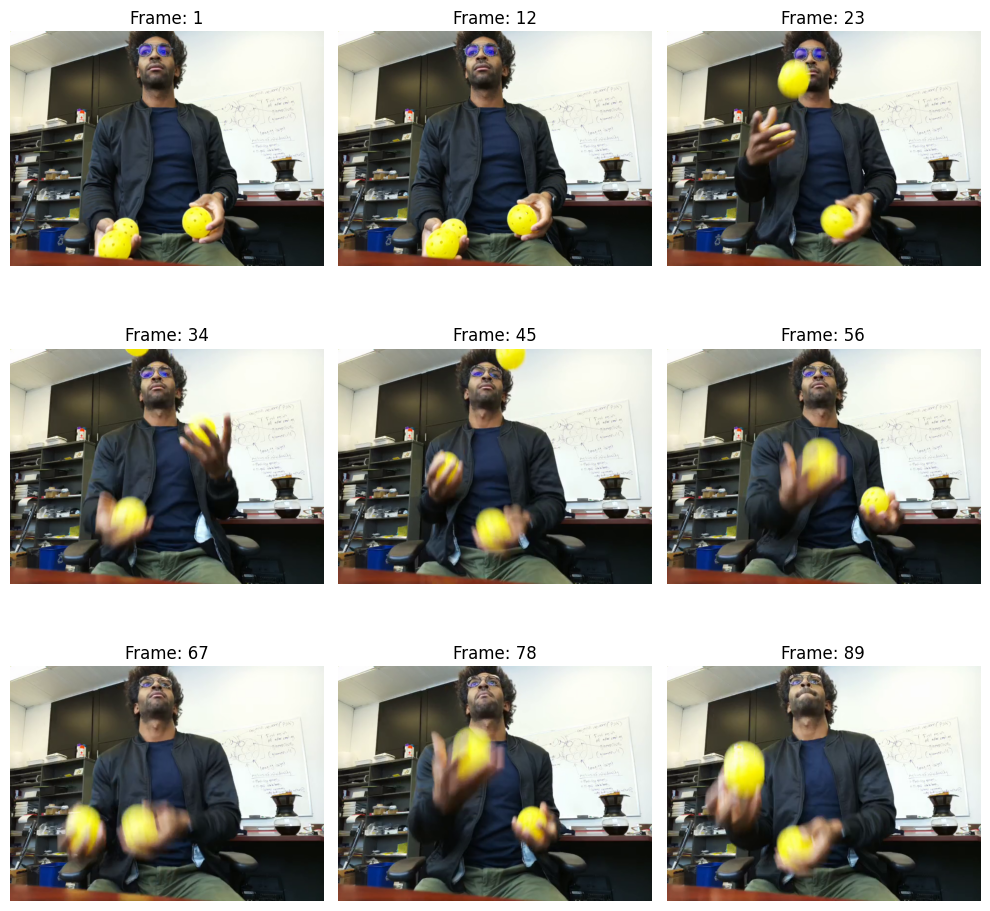

In [ ]:
#@title Visualize a video!
fig,ax = plt.subplots(3,3,figsize=(10,10))

# open the video!
vid1 = cv.VideoCapture(myVideo)
readIn,image = vid1.read()
ax[0,0].imshow(image)
cnt = 0

for xx in range(0,3):
  for yy in range(0,3):

    # read in the next image from the video
    readIn,image = vid1.read()
    cnt+=1

    # plot image sample in new window
    ax[xx,yy].imshow(image[:,:,::-1])

    # turn axis labels off and add a title
    ax[xx,yy].axis('off')
    ax[xx,yy].set_title('Frame: %s'%cnt)

    # skip 10 frames
    [vid1.read() for ele in range(0,10)]
    cnt+=10
plt.tight_layout()
plt.show()

# Now to apply some POSE ESTIMATION

In [ ]:
#@title load the machine learning library
%%capture
!pip install ultralytics

from ultralytics import YOLO

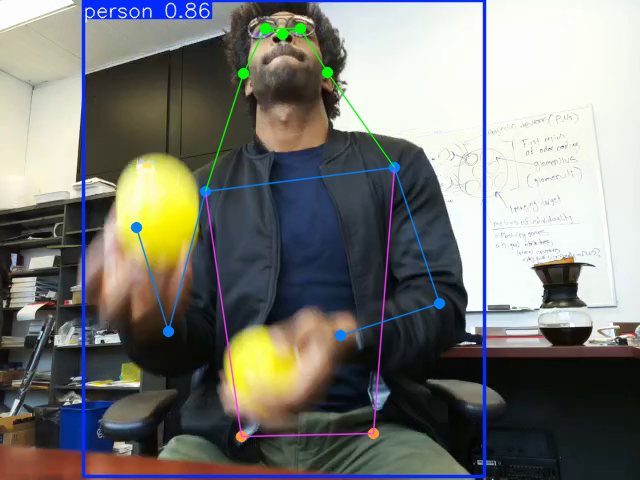

In [ ]:
#@title Load the model and show an example pose estimation!
model = YOLO('/content/biol470/week1/yolo11m-pose.pt')
results = model(image)
results[0].show()

In [ ]:
#@title Create and list all behavior nodes
fKey = {'Nose':[], 'Left Eye':[], 'Right Eye':[],'Left Ear':[],'Right Ear':[],'Left Shoulder':[],'Right Shoulder':[],'Left Elbow':[],'Right Elbow':[],'Left Wrist':[],'Right Wrist':[],'Left Hip':[],'Right Hip':[],'Left Knee':[],'Right Knee':[],'Left Ankle':[],'Right Ankle':[]}
kpoints = list(fKey.keys())

for ele in kpoints:
  print(ele)

Nose
Left Eye
Right Eye
Left Ear
Right Ear
Left Shoulder
Right Shoulder
Left Elbow
Right Elbow
Left Wrist
Right Wrist
Left Hip
Right Hip
Left Knee
Right Knee
Left Ankle
Right


In [ ]:
%%capture
#@title Create a video with the pose overlay
videoIndex = 1

vid1 = cv.VideoCapture(myVideo)
#YOLO()
tempName = myVideo.split('/')[-1]
vidOut1 = cv.VideoWriter('/content/overlay_%s'%tempName,cv.VideoWriter_fourcc('M','J','P','G'), 25, (640,480))
vidOut2 = cv.VideoWriter('/content/pose_%s'%tempName,cv.VideoWriter_fourcc('M','J','P','G'), 25, (640,480))


readIn,image = vid1.read()
while readIn:

  results = model(image)
  out = results[0].plot()
  vidOut1.write(out.astype(np.uint8))

  results[0].orig_img = np.zeros((np.shape(results[0].orig_img)))
  test = results[0].plot()
  vidOut2.write(test.astype(np.uint8))

  if np.shape(results[0].keypoints.data.cpu())[0] == 0:
    print('No keypoints')
  elif np.shape(results[0].keypoints.data.cpu())[0] != 0:
    temp = results[0].keypoints.data[0].cpu()
    if np.shape(temp)[0] == 0:
      print('No detection')
  else:
    for ind,ele in enumerate(kpoints):
      fKey[ele].append(temp[ind].cpu())

  readIn,image = vid1.read()


vid1.release()
vidOut1.release()
vidOut2.release()


speedOut= {}
for ind,ele in enumerate(kpoints):
  speedOut[ele] = []
  for ind2 in range(1,len(fKey[ele])):
    speedOut[ele].append(np.diff(fKey[ele][ind2][:2]-fKey[ele][ind2-1][:2])[0])


dd = pd.DataFrame.from_dict(speedOut)
tt = tempName.split('.')[0]
dd.to_csv(tt+'.csv')